Imports

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import svm
import hashlib
import re


#read from our local copy of the training data
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

train.isnull().sum()

#taking a lot of steps from 
#https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset
#next step - use random forest decision trees
#better explanation of the concepts here https://www.kaggle.com/c/titanic/discussion/10169


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Utilities

In [103]:
#utility to convert one feature of a dataframe to a one-hot dataframe
#input: originaldf (pandas dataframe), feature to remove (string), boolean flag to delete the feature before returning
def onehot_helper(originaldf, feature, remove_original = True):
    
    #turn the categorical data into one-hot dataframe
    dummydf = pd.get_dummies(df[feature],dtype=np.uint8)
    #concatenate the dataframe back onto df
    out = pd.concat([originaldf,dummydf], axis = 1)
    if remove_original:
        originaldf.drop(labels = [feature], inplace = True, axis = 1)
    return(out)

def find_count(input_feature, input_val, output_feature, df):
    sum = 0
    temp = df.loc[df[input_feature] == input_val]
    return temp[output_feature]
    

Data Processing

In [104]:

#read from our local copy of the training data
df = pd.read_csv('titanic/train.csv')
originaldf = df.copy() #save a copy for later


# #our code is in df
# df.describe(include='all')
# #remove columns with missing data
# df.dropna(subset=[n for n in df if n != 'Cabin'], inplace=True)

# #remove columns we don't need
# #justification - Ticket number and name are both unique, unlikely to find patterns unless we do NLP on the names as a proxy for ethnicity/wealth
# df.drop(labels=['Ticket','Name'],inplace=True,axis=1) #inplace true - we aren't making a copy. axis 1, since we are removing a column not a row


# #turn categorical to quantitative
# df = df.replace(to_replace='male', value=1).replace(to_replace='female', value=0)
# #strip away cabin numbers and just leave the cabin grouping (one of 8 letters)
# df['Cabin'] = df['Cabin'].str[0]
# df = onehot_helper(df, 'Cabin', True)


# df.describe(include='all')



In [110]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def get_fare(fare):
    if fare <= 7.91:
        return 0
    elif fare <= 14.545:
        return 1
    elif fare <= 31:
        return 2
    else:
        return 3

def get_age(age):
    if age <= 16:
        return 0
    elif age <= 32:
        return 1
    elif age <= 48:
        return 2
    elif age <= 64:
        return 3
    else:
        return 4

#process both train and test in sync
full_data = [train, test]
# print(data['Embarked'].value_counts())
#use a lamba to create a new feature indicating whether a person has a cabin listed
for i in range(2):
    data['HasCabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data['FamSize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = data['FamSize'].apply(lambda x: 1 if x == 1 else 0)

    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Age'] = data['Age'].apply(get_age)

    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Fare'] = data['Fare'].apply(get_fare)

    data['Sex'] = data['Sex'].apply(lambda x: 0 if x == 'male' else 1)

    embark_map = {'S': 0, 'C': 1, 'Q': 2}
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Embarked'] = data['Embarked'].map(embark_map)

    data['Title'] = data['Name'].apply(get_title)
    data['Title'] = data['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme','Mrs')
    title_map = {'Mr': 1, 'Master': 2, 'Mrs': 3, 'Miss': 4, 'Rare': 5}
    data['Title'] = data['Title'].map(title_map)
    data['Title'] = data['Title'].fillna(0)

    drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'] #Ttitle is an artifact, not supposed to be here
    data = data.drop(drop_elements, axis = 1)
    full_data[i] = data.copy(deep = True)
    print(data.head)(3)
    
print(train.head(3))


<bound method NDFrame.head of      Survived  Pclass  Sex  Age  Parch  Fare  Embarked  HasCabin  FamSize  \
0           0       3    1    0      0     0         0         0        2   
1           1       1    1    0      0     0         0         1        2   
2           1       3    1    0      0     0         0         0        1   
3           1       1    1    0      0     0         0         1        2   
4           0       3    1    0      0     0         0         0        1   
..        ...     ...  ...  ...    ...   ...       ...       ...      ...   
886         0       2    1    0      0     0         0         0        1   
887         1       1    1    0      0     0         0         1        1   
888         0       3    1    0      2     0         0         0        4   
889         1       1    1    0      0     0         0         1        1   
890         0       3    1    0      0     0         0         0        1   

     IsAlone  Title  
0          0      1  
1

TypeError: 'NoneType' object is not callable

In [106]:
# Gini Impurity implementation
def get_gini(survived,total):
    survival_prob = survived/total
    die_prob = 1 - survival_prob
    random_survived_prob = survival_prob
    random_die_prob = 1 - random_survived_prob
    mislabel_survived_prob = die_prob * random_survived_prob
    mislabel_die_prob = survival_prob * random_die_prob
    gini_impurity = mislabel_die_prob + mislabel_survived_prob
    return gini_impurity

# calculates the improvement going from start_split to splitting feature_name, 
# feature_value away from all other values of feature_name
# def find_split_gini( feature_name, feature_value, df):
#     #calculate gini for specified feature
#     temp = find_count(feature_name, feature_value, 'Survived', df)
#     #the survived results is a pandas series with two entries, survived count and dead count, which we grab with the next lines
#     feature_survived = temp.value_counts()[0] #number survived
#     feature_dead = temp.value_counts()[1] #number dead
#     feature_total = feature_survived + feature_dead
#     feature_gini = get_gini(feature_survived, feature_total)

#     #calculate gini for all other features
#     othervals = df[feature_name].unique()
#     val_survived = 0
#     val_dead = 0
#     for val in othervals: #add all the survived/dead from other labels into one pair of survived/dead, calculate its gini impurity
#         if val != feature_value:
#             val_temp = find_count(feature_name, val, 'Survived', df)
#             val_survived += val_temp.value_counts()[0] #number survived
#             val_dead += val_temp.value_counts()[1] #number dead
#     val_total = val_dead + val_survived
#     val_gini = get_gini(val_survived, val_total)

#     #do the weighting
#     total_people = feature_total + val_total
#     feature_weight = feature_total / total_people
#     #print(feature_weight)
#     val_weight = val_total / total_people
#     #print(val_weight)
#     weighted_gini = (feature_gini * feature_weight) + (val_gini * val_weight)
#     #print(feature_gini, val_gini)
#     return weighted_gini

def find_split_gini( feature_name, feature_value, df):
    #calculate gini for specified feature
    temp = find_count(feature_name, feature_value, 'Survived', df)
    #the survived results is a pandas series with two entries, survived count and dead count, which we grab with the next lines
    feature_survived = temp.value_counts()[0] #number survived
    feature_dead = temp.value_counts()[1] #number dead
    feature_total = feature_survived + feature_dead
    feature_gini = get_gini(feature_survived, feature_total)

    #calculate gini for all other features
    othervals = df[feature_name].unique()
    val_survived = 0
    val_dead = 0
    for val in othervals: #add all the survived/dead from other labels into one pair of survived/dead, calculate its gini impurity
        if val != feature_value:
            val_temp = find_count(feature_name, val, 'Survived', df)
            val_survived += val_temp.value_counts()[0] #number survived
            val_dead += val_temp.value_counts()[1] #number dead
    val_total = val_dead + val_survived
    val_gini = get_gini(val_survived, val_total)

    #do the weighting
    total_people = feature_total + val_total
    feature_weight = feature_total / total_people
    #print(feature_weight)
    val_weight = val_total / total_people
    #print(val_weight)
    weighted_gini = (feature_gini * feature_weight) + (val_gini * val_weight)
    #print(feature_gini, val_gini)
    return weighted_gini

            

#finds the best features in df to minimize gini impurity. to_skip are columns we've already considered - we skip
def find_best_features(df, to_skip):
    possible_features = [] #holds tuples with feature:value pairs
    impurities = []
    for col in data.columns:
        #skip the target label - in titanic, should be survived - illogical and causes errors
        if col in to_skip: 
            continue
        
        features = df[col].unique()
        #print("-------\n", col, "\n", features)
        #case where we have a binary choice - just pick the first one
        if len(features) == 2:
            possible_features.append((col, features[0]))
        #case where we have a lot of features - add them all
        elif len(features) > 2:
            for f in features:
                possible_features.append((col, f))
    #construct a list of tuples like (feature, value, gini impurity)
    #RIGHT NOW WE ARE JUST DISCARDING ANY FEATURES THAT THROW ERRORS
    for feature in possible_features:
        try:
            impurities.append((feature[0], feature[1], find_split_gini(feature[0], feature[1], df)))
        except:
            pass
            #print("error thrown by: \n", feature[0], "\n", feature[1])
    #sorts the tuples by their last element
    impurities = sorted(impurities, key = lambda x: x[2]) 
    tuplist= []
    length = len(impurities)
    i = 0
    #removes all duplicate features, keeping the first occurence only
    # since the list is sorted, this means keeping the ones with best gini impurity
    while i < length:
        if impurities[i][0] not in tuplist:
            tuplist.append(impurities[i][0])
            i += 1
        else:
            del impurities[i]
            length -= 1
    return impurities


In [107]:
#testing the way i rolled to find gini impurity and determine the most decisive features
best = find_best_features(data,['Survived'])
print('\n'.join(str(tup) for tup in best))
test.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamSize,IsAlone,Title
0,892,3,"Kelly, Mr. James",0,2,0,0,330911,0,NaN,2,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,363272,0,NaN,0,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,240276,1,NaN,2,0,1,1,1
3,895,3,"Wirz, Mr. Albert",0,1,0,0,315154,1,NaN,0,0,1,1,1


In [108]:
#using cross-validation to find the best tree depth
#pretty much copying this part from https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset
#data needs to be our training data, since train is raw and not cleaned

cv = KFold(n_splits=10)
accuracy_list = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_acc = []
    tree_model = tree.DecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(data):
        f_train = data.loc[train_fold]
        f_valid = data.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['Survived'], axis = 1),
                            y = f_train['Survived'])
        validation = model.score(X = f_valid.drop(['Survived'], axis = 1),
                            y = f_valid['Survived'])
        fold_acc.append(validation)

    avg = sum(fold_acc)/len(fold_acc)
    accuracy_list.append(avg)
    # print("Average accuracy: ", avg)
    # print("\n")

#ok, it seems like the best tree depth is 3, with avg of 82.8% accuracy

KeyError: "['Survived'] not found in axis"

In [ ]:
#making the final tree

y_train = data['Survived']
x_train = data.drop(['Survived'], axis =1).values
x_test = test.values



Data Visualization

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

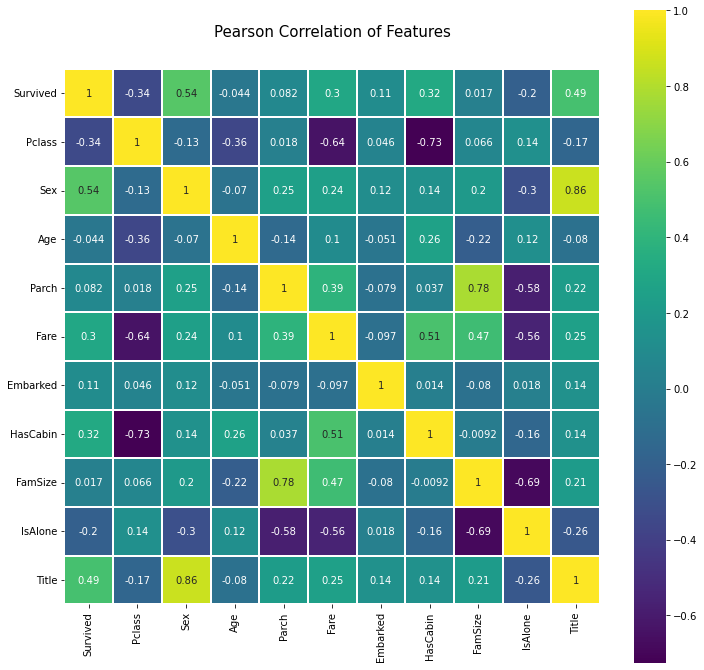

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title("Pearson Correlation of Features", y=1.05, size = 15)
sns.heatmap(data.astype(float).corr(),linewidths=0.05, vmax=1.0, square = True, cmap = colormap, linecolor = 'white', annot=True)


<Figure size 432x288 with 0 Axes>

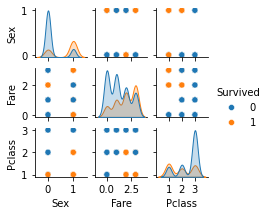

In [ ]:

plt.figure()
data.head(3)
train.head(2)
train.describe(include='all')
#df.describe(include="all")
new = data
# plt.figure()
sns.pairplot(new, vars = ['Sex','Fare','Pclass'],hue = "Survived",height = 1)
# plt.show()

#sns.pairplot(df, vars = ['A','B','C','D','E','F','G','T'],hue = "Survived")

plt.show()

Testing